# Ejemplo del uso de Redes Neuronales con MLP de **Sklearn**

Estos ejemplos muestran cómo crear una red neuronal desde cero y cómo entrenar una red neuronal usando sklearn.

## Librerias


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from   sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

## Datasets

En estos ejemplos, utilizaremos las siguientes bases de datos de características para probar clasificadores:

* F2: Datos de entrenamiento: 800 muestras con 2 características. Datos de prueba: 400 muestras con 2 características. Clases: 0...1

* G2: Datos de entrenamiento: 800 muestras con 2 características. Datos de prueba: 200 muestras con 2 características. Clases: 1...2

* G3: Datos de entrenamiento: 1200 muestras con 2 características. Datos de prueba: 600 muestras con 2 características. Clases: 1...3

* G4: Datos de entrenamiento: 800 muestras con 2 características. Datos de prueba: 400 muestras con 2 características. Clases: 1...4

* P2: Datos de entrenamiento: 1052 muestras con 2 características. Datos de prueba: 262 muestras con 2 características. Clases: 0...1

In [ ]:
!wget https://www.dropbox.com/s/3w6k7vu3xpesjxh/F2.zip
!unzip -qq F2

!wget https://www.dropbox.com/s/bqfrgjvijpn6rrg/G2.zip
!unzip -qq G2

!wget https://www.dropbox.com/s/eg2wx2ari93n8y7/G3.zip
!unzip -qq G3

!wget https://www.dropbox.com/s/zz51gdrltuoy2fo/G4.zip
!unzip -qq G4

!wget https://www.dropbox.com/s/a0egs8asnwdda4o/P2.zip
!unzip -qq P2

print('Dataset F2, G2, G3, G4 y P2 loaded.')


--2024-06-17 19:39:23--  https://www.dropbox.com/s/3w6k7vu3xpesjxh/F2.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/vpvbbjxnjg5b0b9dath1w/F2.zip?rlkey=xy0zpuynmifsvwrja96t9va4b [following]
--2024-06-17 19:39:23--  https://www.dropbox.com/scl/fi/vpvbbjxnjg5b0b9dath1w/F2.zip?rlkey=xy0zpuynmifsvwrja96t9va4b
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc21c6127716a9792ba36b363f71.dl.dropboxusercontent.com/cd/0/inline/CVASKA9sjWunBZOf0sVXnMyMSdjq5RRzl2zHg7vaukIw6WIvqrTH8FM9y12c2grgjK70cpz_TXrBDNtOFPBUvrT7tgrDoWbO_xARPGLMhcM953yzxOvn2nFA45_67HA6-y0/file# [following]
--2024-06-17 19:39:24--  https://uc21c6127716a9792ba36b363f71.dl.dropboxusercontent.com/cd/0/inline/CVASKA9sjWunBZOf0sVXnMyMSdjq5RRzl2zHg

## Funciones

Definimos una serie de funciones para cargar las características de los datos, graficarlas, graficar las líneas de clasificación de los algoritmos y mostrar los resultados de las clasificaciones.

In [ ]:
def load_features(prefix):
    Xtrain  = np.load(prefix+'_Xtrain.npy')            # training samples
    Xtest = np.load(prefix+'_Xtest.npy')             # testing samples
    ytrain  = np.ravel(np.load(prefix+'_dtrain.npy'))  # training labels
    ytest = np.ravel(np.load(prefix+'_dtest.npy'))   # testing labels
    print('Training data: '+str(Xtrain.shape[0]) +' samples with '+str(Xtrain.shape[1]) +' features')
    print(' Testing data: '+str(Xtest.shape[0])+' samples with '+str(Xtest.shape[1])+' features')
    print('      Classes: '+str(int(np.min(ytrain)))+'...'+str(int(np.max(ytrain))))
    return Xtrain,ytrain,Xtest,ytest

def print_confusion(dt,ds,show_heatmap=0,Cnorm=1):
    # dt - true, ds - predicted
    C   = confusion_matrix(dt,ds)
    print('Confusion Matrix:')
    print(C)
    acc = accuracy_score(dt,ds)
    acc_st = "{:.2f}".format(acc*100)
    print('Accuracy = '+str(acc_st))
    if show_heatmap:
      sns.heatmap(C/Cnorm, annot=True, cbar=None, cmap="Blues")
      plt.title("Confusion Matrix"), plt.tight_layout()
      plt.ylabel("True Class"), plt.xlabel("Predicted Class")
      plt.show()

def plot_features(X,d,st,show=1):
    dmin = int(np.min(d))
    dmax = int(np.max(d))
    #colors = np.array(["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta"])
    #colors = 'Greens'
    for j in range(dmin,dmax+1):
        plt.scatter(X[d==j,0],X[d==j,1],label=str(j),s=27)
    plt.grid(True)
    plt.legend()
    plt.xlabel('$x_1$',fontsize=14)
    plt.ylabel('$x_2$',fontsize=14)
    plt.title('Feature Space - '+st,fontsize=14)
    if show==1:
        plt.show()

def plot_decision_lines(clf,X,show=0,decisionline=1):
    # based on example of https://scikit-learn.org
    h = 0.075
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    if decisionline == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Reds, alpha=0.8)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    if show==1:
        plt.show()

def show_clf_results(clf,X,d,Xt,dt,d0,ds,st,decisionline=1):
    gs = gridspec.GridSpec(1, 2)
    fig = plt.figure(figsize=(18, 6))
    print('Training:')
    acc = accuracy_score(d,d0)
    accst = f'Acc = {acc:.4f}'
    ax = plt.subplot(gs[0,0])
    print_confusion(d,d0)                             # confusion matrix in training
    plot_decision_lines(clf,X,0,decisionline)          # decision lines
    plot_features(X,d,st+' - Training: '+accst,0)     # feature space in training
    ax = plt.subplot(gs[0,1])
    print('Testing:')
    acc = accuracy_score(ds,dt)
    accst = f'Acc = {acc:.4f}'
    print_confusion(dt,ds)                            # confusion matrix in testing
    plot_decision_lines(clf,X,0,decisionline)          # decision lines
    plot_features(Xt,dt,st+' - Testing: '+accst,1)    # feature space in testing


def plot_loss(loss_train):
    plt.figure(figsize=[8,6])
    plt.plot(loss_train,'r',linewidth=1.5)
    # plt.plot(loss_val,'b',linewidth=1.5)
    # plt.legend(['Training loss', 'Validation Loss'],fontsize=14)
    plt.xlabel('Epochs ',fontsize=14)
    plt.ylabel('Loss',fontsize=14)
    plt.title('Training Loss',fontsize=14)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
    plt.grid(True)
    plt.show()


## Separación entre Training y Testing

Separamos los datos en entrenamiento y testeo y los graficamos con las funciones definidas anteriormente.

Loading G4...
Training data: 800 samples with 2 features
 Testing data: 400 samples with 2 features
      Classes: 1...4


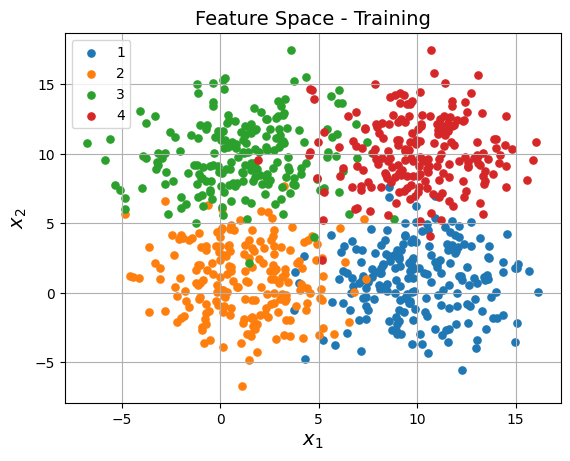

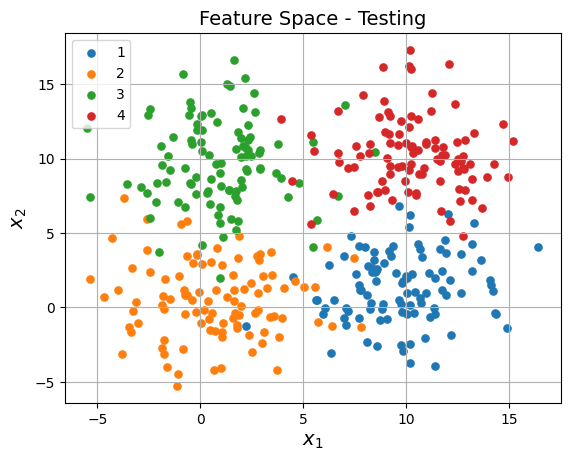

In [ ]:
data = 'G4' # <= it can be 'G2','G3','G4','P2','F2'
print('Loading '+data+'...')

Xtrain,ytrain,Xtest,ytest   = load_features(data + '/' + data)   # load training and testing data

plot_features(Xtrain,ytrain,'Training')
plot_features(Xtest,ytest,'Testing')


## Redes neuronales

En este ejemplo, entrenaremos una red neuronal como se muestra en la figura: 2 características de entrada ($x_1,x_2$), 3 capas (2 capas ocultas: ${\bf a}_1$ con 6 nodos y ${\bf a}_2$ con 12 nodos), y una salida de 4 elementos, es decir, 4 clases, similar a la base de datos `G4`.

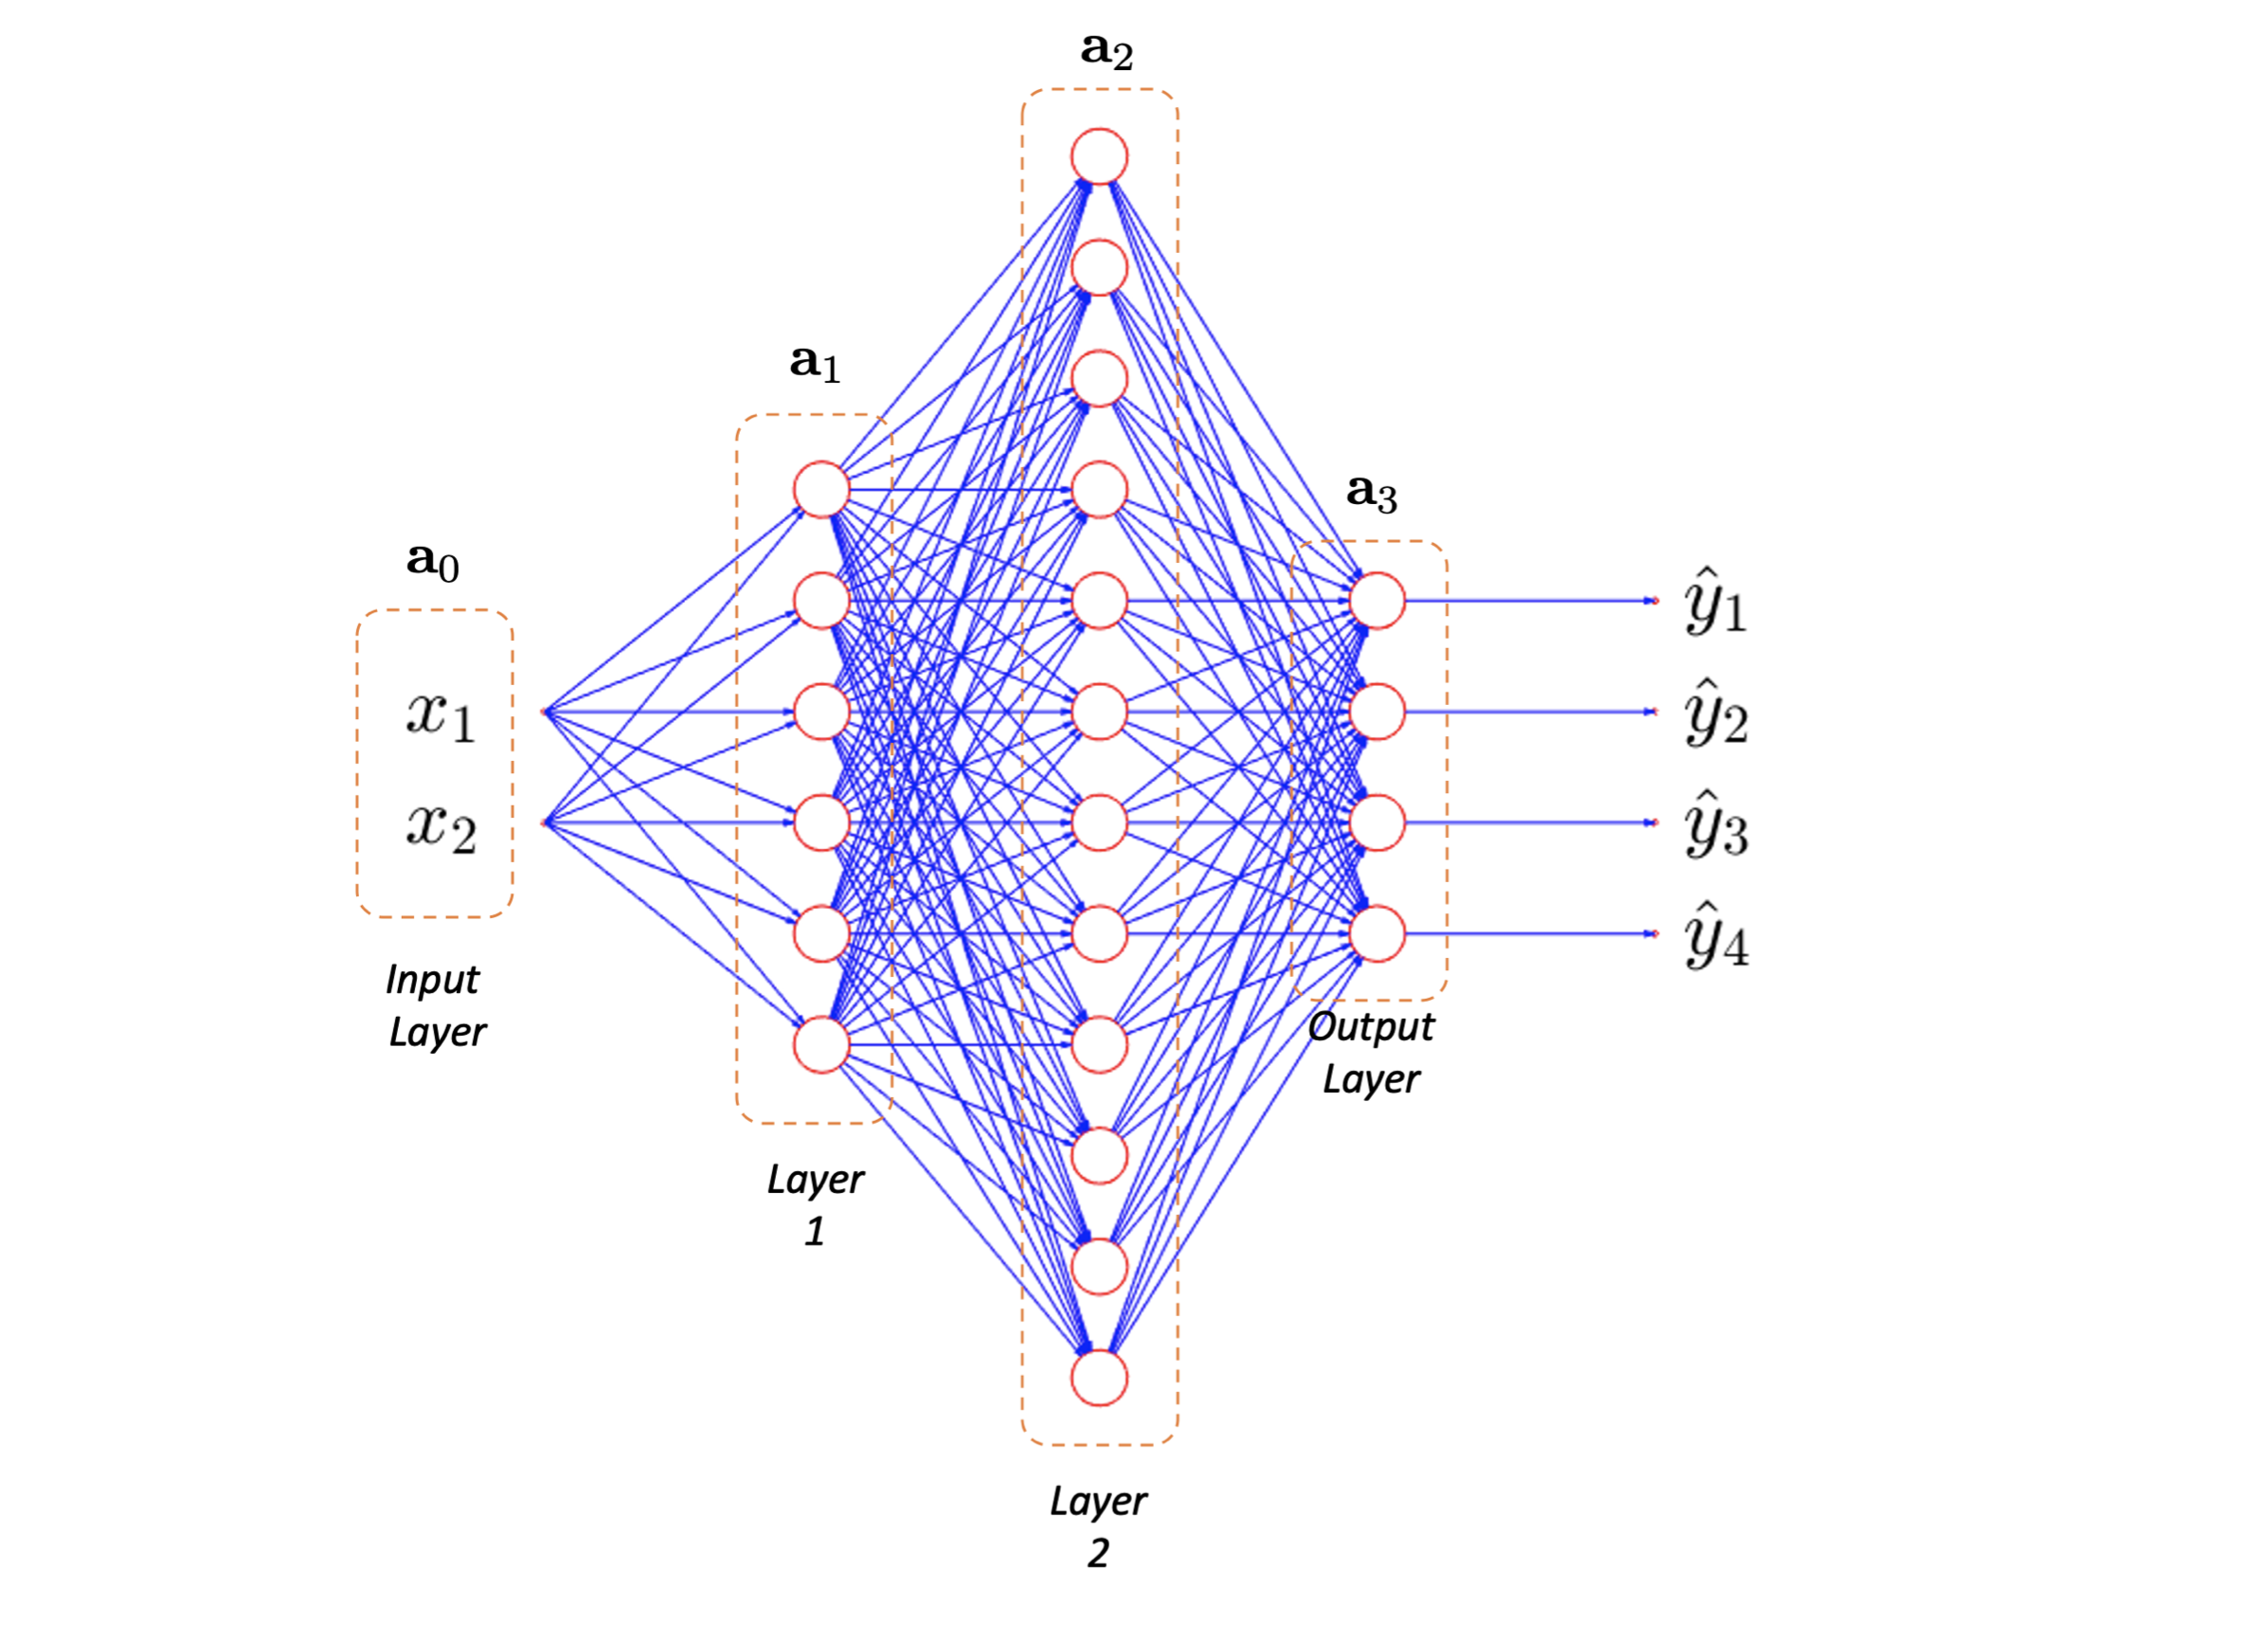

## Redes neuronales (sklearn)

Esta implementación de redes neuronales se utiliza en la práctica.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training:
Confusion Matrix:
[[192   2   0   6]
 [ 36 135  25   4]
 [  0   1 186  13]
 [  6   0   9 185]]
Accuracy = 87.25
Testing:
Confusion Matrix:
[[94  1  0  5]
 [17 74  8  1]
 [ 0  1 95  4]
 [ 3  0  5 92]]
Accuracy = 88.75


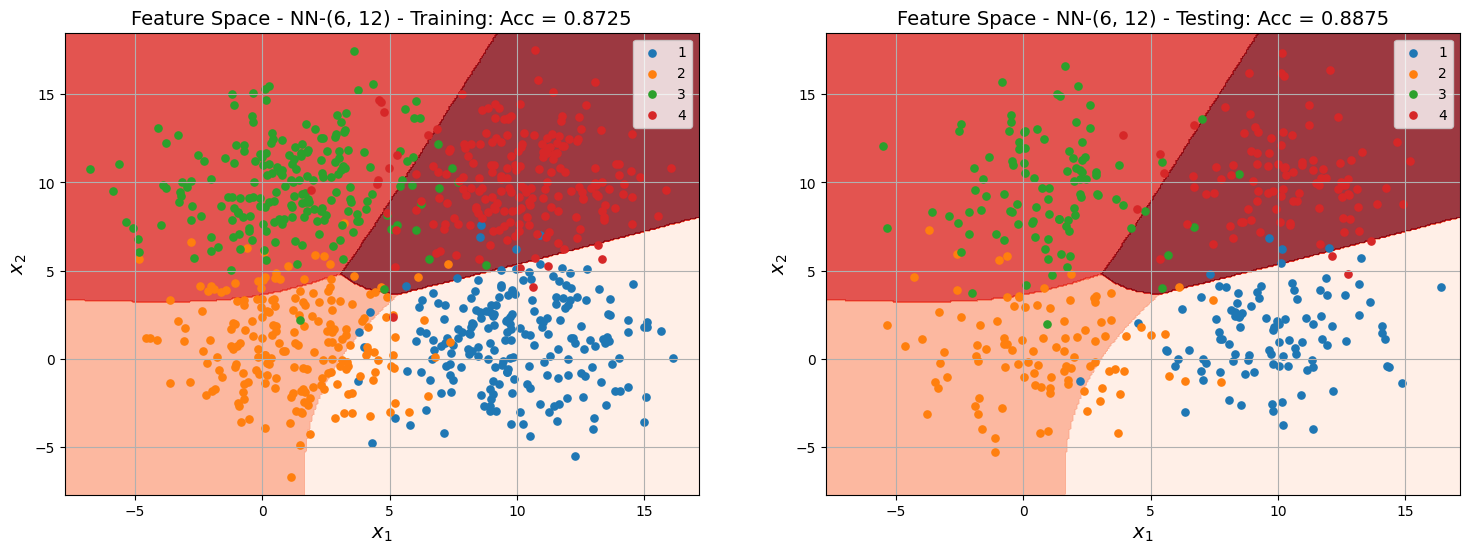

In [ ]:
from sklearn.neural_network import MLPClassifier

# Definiciones
lr          = 1e-3     # tasa de aprendizaje

# Dos capas ocultas, la primera con 6, la segunda con 12 nodos
nh          = (6,12)   # nodos de las capas ocultas

tmax        = 2000     # número máximo de iteraciones
solver      = 'sgd'   # método de optimización ('lbfgs','sgd', 'adam')
nn_st       = 'NN-'+str(nh)
activation   = 'logistic'   # función de activación ('identity', 'logistic', 'tanh', 'relu'), logistic es la sigmoidal


# Entrenamiento
clf = MLPClassifier(solver=solver, learning_rate_init = lr,hidden_layer_sizes=nh, activation=activation,
                    random_state=1,max_iter=tmax)
clf.fit(Xtrain, ytrain)

# Evaluación en el subconjunto de entrenamiento
y0  = clf.predict(Xtrain)

# Evaluación en el subconjunto de prueba
ypred  = clf.predict(Xtest)

# Mostrar resultados
show_clf_results(clf,Xtrain,ytrain,Xtest,ytest,y0,ypred,nn_st,decisionline=1)


Training:
Confusion Matrix:
[[188   5   0   7]
 [ 11 172  15   2]
 [  0   2 184  14]
 [  5   1   9 185]]
Accuracy = 91.12
Testing:
Confusion Matrix:
[[93  2  0  5]
 [ 6 88  5  1]
 [ 0  3 91  6]
 [ 3  0  5 92]]
Accuracy = 91.00


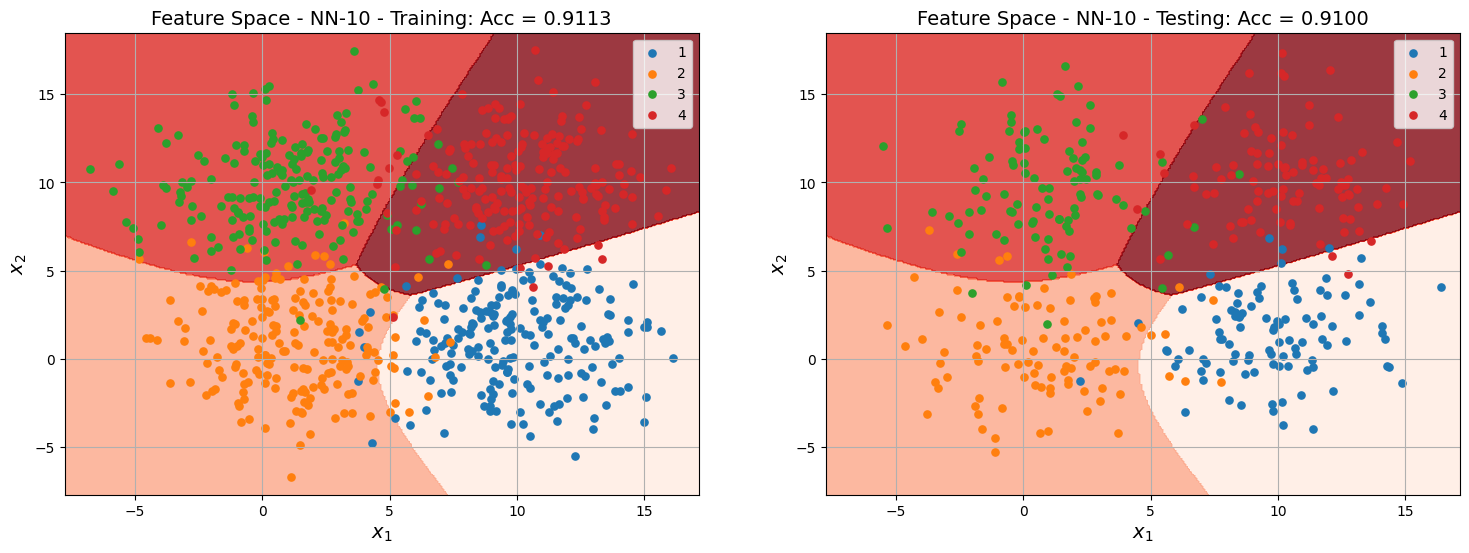

In [ ]:
from sklearn.neural_network import MLPClassifier

# Definiciones
lr          = 1e-3     # tasa de aprendizaje

# Una sola capa con 10 nodos
nh          = 10   # nodos de las capas ocultas

tmax        = 2000     # número máximo de iteraciones
solver      = 'sgd'   # método de optimización ('lbfgs','sgd', 'adam')
activation   = 'logistic'   # función de activación ('identity', 'logistic', 'tanh', 'relu'), logistic es la sigmoidal
nn_st       = 'NN-'+str(nh)

# Entrenamiento
clf = MLPClassifier(solver=solver, learning_rate_init = lr,hidden_layer_sizes=nh, activation=activation,
                    random_state=1,max_iter=tmax)
clf.fit(Xtrain, ytrain)

# Evaluación en el subconjunto de entrenamiento
y0  = clf.predict(Xtrain)

# Evaluación en el subconjunto de prueba
ypred  = clf.predict(Xtest)

# Mostrar resultados
show_clf_results(clf,Xtrain,ytrain,Xtest,ytest,y0,ypred,nn_st,decisionline=1)


Training:
Confusion Matrix:
[[189   7   0   4]
 [  6 187   6   1]
 [  1   5 184  10]
 [  4   2  11 183]]
Accuracy = 92.88
Testing:
Confusion Matrix:
[[95  2  0  3]
 [ 6 90  4  0]
 [ 0  7 89  4]
 [ 2  1  4 93]]
Accuracy = 91.75


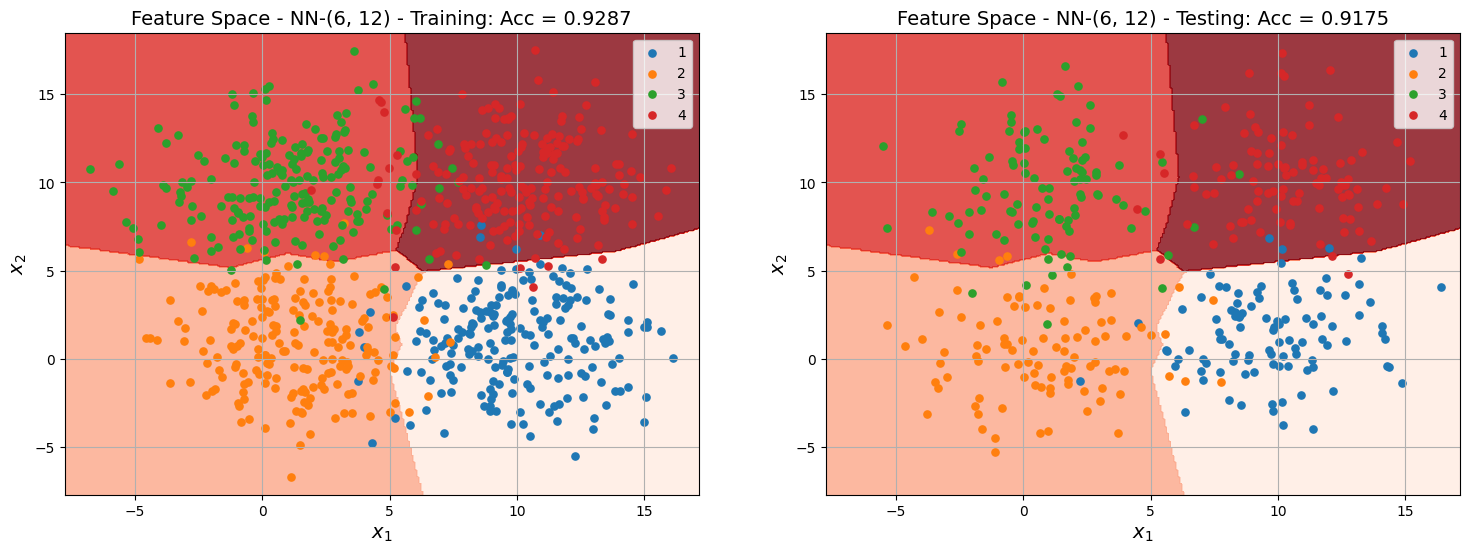

In [ ]:
from sklearn.neural_network import MLPClassifier

# Definiciones
lr          = 1e-3     # tasa de aprendizaje

# Dos capas ocultas, la primera con 6, la segunda con 12 nodos
nh          = (6,12)   # nodos de las capas ocultas

tmax        = 2000     # número máximo de iteraciones
solver      = 'adam'   # método de optimización ('lbfgs','sgd', 'adam')
activation   = 'relu'   # función de activación ('identity', 'logistic', 'tanh', 'relu')
nn_st       = 'NN-'+str(nh)

# Entrenamiento
clf = MLPClassifier(solver=solver, learning_rate_init = lr,hidden_layer_sizes=nh, activation=activation,
                    random_state=1,max_iter=tmax)
clf.fit(Xtrain, ytrain)

# Evaluación en el subconjunto de entrenamiento
y0  = clf.predict(Xtrain)

# Evaluación en el subconjunto de prueba
ypred  = clf.predict(Xtest)

# Mostrar resultados
show_clf_results(clf,Xtrain,ytrain,Xtest,ytest,y0,ypred,nn_st,decisionline=1)


Training:
Confusion Matrix:
[[189   7   0   4]
 [  8 184   7   1]
 [  0   5 182  13]
 [  4   2  10 184]]
Accuracy = 92.38
Testing:
Confusion Matrix:
[[94  2  0  4]
 [ 6 91  3  0]
 [ 0  6 90  4]
 [ 1  0  5 94]]
Accuracy = 92.25


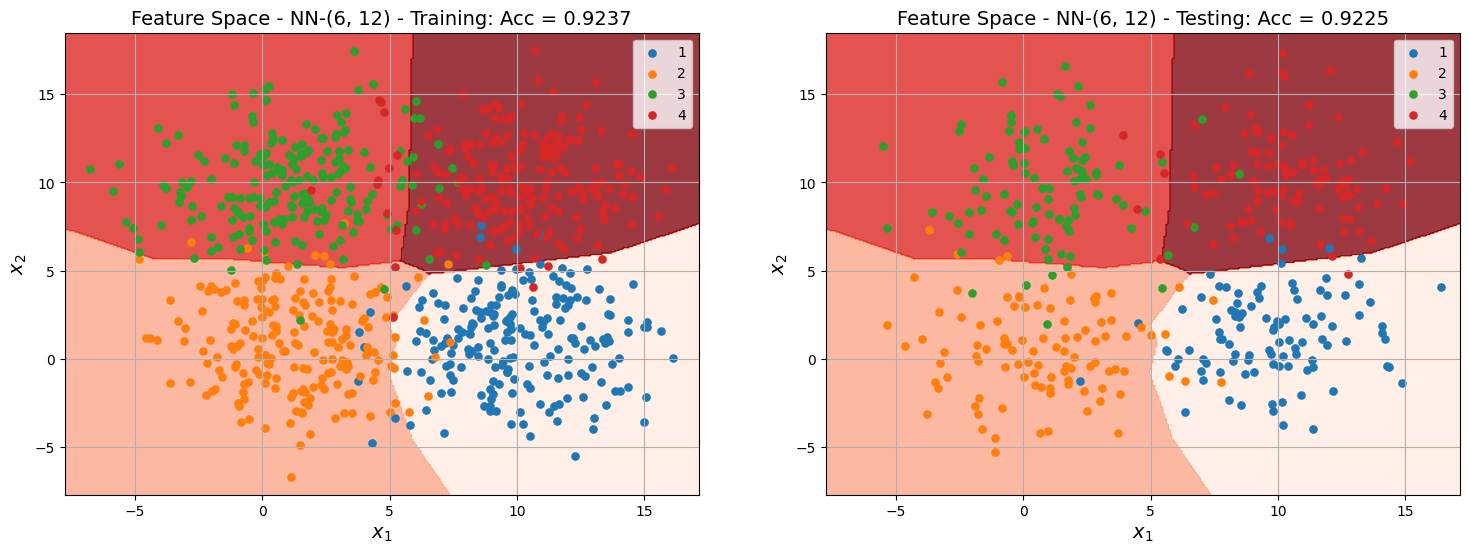

In [ ]:
from sklearn.neural_network import MLPClassifier

# Definiciones
lr          = 1e-3     # tasa de aprendizaje

# Dos capas ocultas, la primera con 6, la segunda con 12 nodos
nh          = (6,12)   # nodos de las capas ocultas

tmax        = 2000     # número máximo de iteraciones
solver      = 'sgd'   # método de optimización ('lbfgs','sgd', 'adam')
activation   = 'relu'   # función de activación ('identity', 'logistic', 'tanh', 'relu')
nn_st       = 'NN-'+str(nh)

# Entrenamiento
clf = MLPClassifier(solver=solver, learning_rate_init = lr,hidden_layer_sizes=nh, activation=activation,
                    random_state=1,max_iter=tmax)
clf.fit(Xtrain, ytrain)

# Evaluación en el subconjunto de entrenamiento
y0  = clf.predict(Xtrain)

# Evaluación en el subconjunto de prueba
ypred  = clf.predict(Xtest)

# Mostrar resultados
show_clf_results(clf,Xtrain,ytrain,Xtest,ytest,y0,ypred,nn_st,decisionline=1)


# Ejemplo 1 de clasificación con NN de **PyTorch**

Data set extraído de https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv

## Importación de librerías y visualización de datos

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [ ]:
from google.colab import files

uploaded = files.upload()
uploaded = files.upload()

Saving diabetes.csv to diabetes (1).csv


Saving pima-indians-diabetes.csv to pima-indians-diabetes.csv


In [ ]:
df = pd.read_csv('diabetes.csv', header=0)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Separamos en train/test

Los datos se almacenarán en una matriz 2D donde la primera dimensión son filas y la segunda dimensión son columnas, por ejemplo, (filas, columnas). Dividimos la matriz en dos matrices seleccionando subconjuntos de columnas utilizando el operador de corte estándar de NumPy ":". Seleccionamos las primeras ocho columnas desde el índice 0 hasta el índice 7 a través del corte 0:8. Luego, seleccionamos la columna de salida (la 9ª variable) a través del índice 8.

In [ ]:
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
X = dataset[:,0:8]
y = dataset[:,8]

Estos datos deben convertirse primero a tensores de PyTorch, porque convertir a tensores de PyTorch puede evitar la conversión implícita que puede causar problemas. Para convertir, creamos un tensor a partir de arrays de NumPy:

In [ ]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

## Definimos la red neuronal con NN

**Observaciones**
- Para la capa de entrada, debemos establecer una cantidad de entradas igual a la cantidad de atributos que tienen los datos, que en este caso es 8.
- La cantidad de salidas de una capa debe ser igual a la cantidad de entradas de la capa siguiente.
- La capa de salida debe tener un output, ya que es un problema de clasificación binaria.

In [ ]:
# Definimos una clase Net que hereda de nn.Module para crear nuestra red neuronal personalizada
class Net(nn.Module):
    # Definimos el constructor de la clase
    def __init__(self):
        super().__init__()  # Inicializa la clase base nn.Module
        self.hidden1 = nn.Linear(8, 12)  # Define la primera capa oculta con 8 entradas y 12 salidas
        self.act1 = nn.ReLU()  # Define la función de activación ReLU para la primera capa oculta
        self.hidden2 = nn.Linear(12, 8)  # Define la segunda capa oculta con 12 entradas y 8 salidas
        self.act2 = nn.ReLU()  # Define la función de activación ReLU para la segunda capa oculta
        self.output = nn.Linear(8, 1)  # Define la capa de salida con 8 entradas y 1 salida
        self.act_output = nn.Sigmoid()  # Define la función de activación Sigmoid para la capa de salida

    # Definimos el método forward que especifica cómo se pasan los datos a través de la red
    def forward(self, x):
        x = self.act1(self.hidden1(x))  # Pasa los datos por la primera capa oculta y aplica ReLU
        x = self.act2(self.hidden2(x))  # Pasa los datos por la segunda capa oculta y aplica ReLU
        x = self.act_output(self.output(x))  # Pasa los datos por la capa de salida y aplica Sigmoid
        return x  # Devuelve la salida final

# Creamos una instancia de la red neuronal definida
model = Net()

# Imprimimos la arquitectura de la red neuronal
print(model)

Net(
  (hidden1): Linear(in_features=8, out_features=12, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=12, out_features=8, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (act_output): Sigmoid()
)


## Definimos la función de pérdida y el optimizador

In [ ]:
loss_fn = nn.BCELoss()  # Función de pérdida como Entropía Cruzada Binaria (Binary Cross Entropy), que se utiliza comúnmente para tareas de clasificación binaria.
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam con una tasa de aprendizaje de 0.001, optimizando los parámetros del modelo.

## Entrenamiento, cálculo de pérdida y optimización por etapas

In [ ]:
n_epochs = 100  # Define el número de épocas (veces que se pasa todo el conjunto de datos por el modelo) en 100.
batch_size = 10  # Define el tamaño de los lotes en 10 (cantidad de muestras que se pasan al modelo en cada iteración).

# Bucle para iterar a través de todas las épocas
for epoch in range(n_epochs):
    # Bucle para iterar a través de los datos en lotes
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]  # Selecciona un lote de datos de entrada desde el índice i hasta i + batch_size.
        y_pred = model(Xbatch)  # Realiza una predicción pasando el lote de datos a través del modelo.
        ybatch = y[i:i+batch_size]  # Selecciona el lote correspondiente de datos de salida (etiquetas) desde el índice i hasta i + batch_size.
        loss = loss_fn(y_pred, ybatch)  # Calcula la pérdida entre las predicciones y las etiquetas reales utilizando la función de pérdida definida.

        optimizer.zero_grad()  # Reinicia los gradientes de los parámetros del modelo antes de realizar la retropropagación.
        loss.backward()  # Realiza la retropropagación para calcular los gradientes de la pérdida respecto a los parámetros del modelo.
        optimizer.step()  # Actualiza los parámetros del modelo utilizando los gradientes calculados por el optimizador.

    # Imprime el estado actual al final de cada época
    print(f'Finished epoch {epoch}, latest loss {loss}')  # Muestra un mensaje indicando que se ha terminado la época actual y muestra la última pérdida calculada.


Finished epoch 0, latest loss 0.37549012899398804
Finished epoch 1, latest loss 0.37874865531921387
Finished epoch 2, latest loss 0.37949153780937195
Finished epoch 3, latest loss 0.38577771186828613
Finished epoch 4, latest loss 0.3700558841228485
Finished epoch 5, latest loss 0.380240261554718
Finished epoch 6, latest loss 0.37638306617736816
Finished epoch 7, latest loss 0.3680594265460968
Finished epoch 8, latest loss 0.36613357067108154
Finished epoch 9, latest loss 0.3891514837741852
Finished epoch 10, latest loss 0.3691054582595825
Finished epoch 11, latest loss 0.38340672850608826
Finished epoch 12, latest loss 0.36339855194091797
Finished epoch 13, latest loss 0.3615969717502594
Finished epoch 14, latest loss 0.3656594753265381
Finished epoch 15, latest loss 0.36550435423851013
Finished epoch 16, latest loss 0.36277660727500916
Finished epoch 17, latest loss 0.36378031969070435
Finished epoch 18, latest loss 0.3648250997066498
Finished epoch 19, latest loss 0.3589729368686676


## Predecimos resultados y evaluamos el modelo

In [ ]:
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(X)

accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.7604166865348816


In [ ]:
print(classification_report(y, y_pred.round()))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       500
         1.0       0.71      0.53      0.61       268

    accuracy                           0.76       768
   macro avg       0.74      0.71      0.72       768
weighted avg       0.75      0.76      0.75       768



In [ ]:
# make class predictions with the model
predictions = (model(X) > 0.5).int()
for i in range(10):
    print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

[6.0, 148.0, 72.0, 35.0, 0.0, 33.599998474121094, 0.6269999742507935, 50.0] => 1 (expected 1)
[1.0, 85.0, 66.0, 29.0, 0.0, 26.600000381469727, 0.35100001096725464, 31.0] => 0 (expected 0)
[8.0, 183.0, 64.0, 0.0, 0.0, 23.299999237060547, 0.671999990940094, 32.0] => 1 (expected 1)
[1.0, 89.0, 66.0, 23.0, 94.0, 28.100000381469727, 0.16699999570846558, 21.0] => 0 (expected 0)
[0.0, 137.0, 40.0, 35.0, 168.0, 43.099998474121094, 2.2880001068115234, 33.0] => 1 (expected 1)
[5.0, 116.0, 74.0, 0.0, 0.0, 25.600000381469727, 0.20100000500679016, 30.0] => 0 (expected 0)
[3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.24799999594688416, 26.0] => 0 (expected 1)
[10.0, 115.0, 0.0, 0.0, 0.0, 35.29999923706055, 0.1340000033378601, 29.0] => 1 (expected 0)
[2.0, 197.0, 70.0, 45.0, 543.0, 30.5, 0.15800000727176666, 53.0] => 1 (expected 1)
[8.0, 125.0, 96.0, 0.0, 0.0, 0.0, 0.23199999332427979, 54.0] => 0 (expected 1)


# Ejemplo 2 de clasificación con NN de **PyTorch**

Neural Networks for MNIST dataset

By Kevin Vu, Exxact Corp.


https://www.kdnuggets.com/2020/10/building-neural-networks-pytorch-google-colab.html

Tutorial de la documentación de PyTorch para la creación de redes neuronales:
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

## Importamos las librerías

In [ ]:
# Import libraries
import torch
import torchvision
from   torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from   tqdm.auto import tqdm

## Separamos en train y test

In [ ]:
train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5434944.50it/s] 


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160284.56it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 603977.12it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4083714.63it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



Imprimimos 10 ejemplos para visualizar los datos

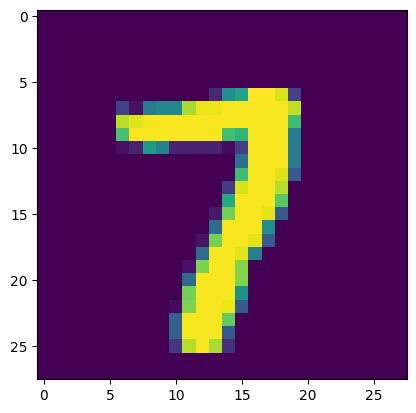

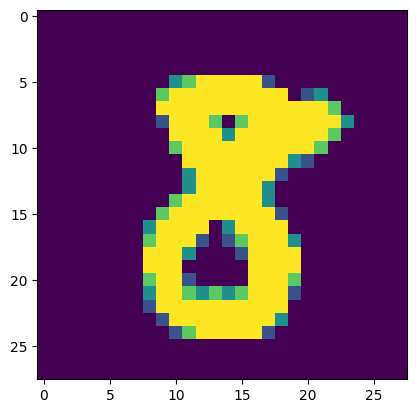

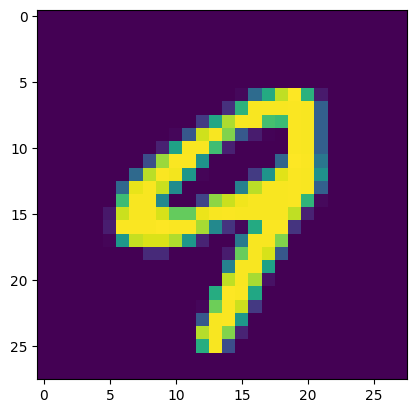

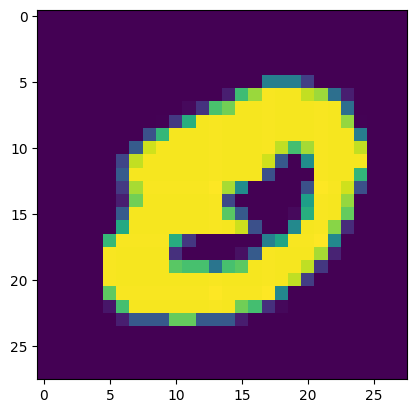

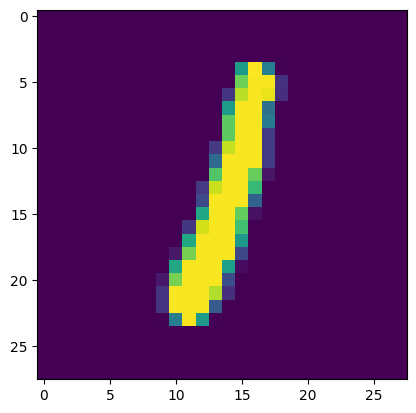

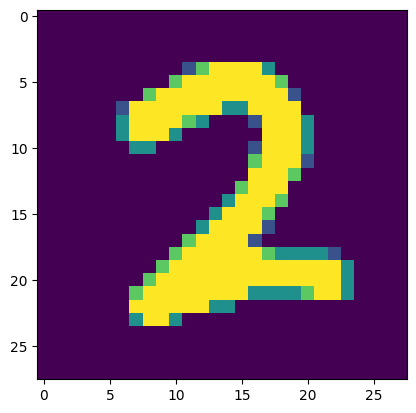

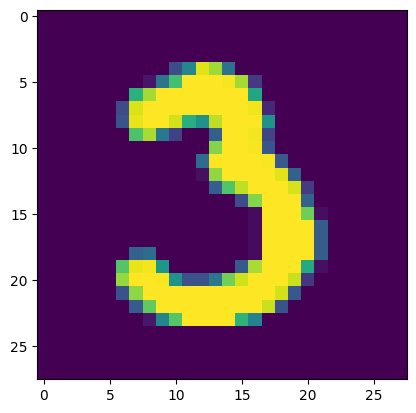

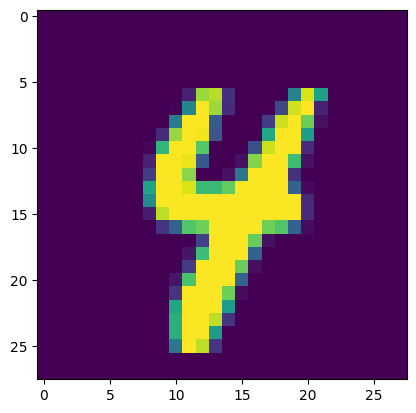

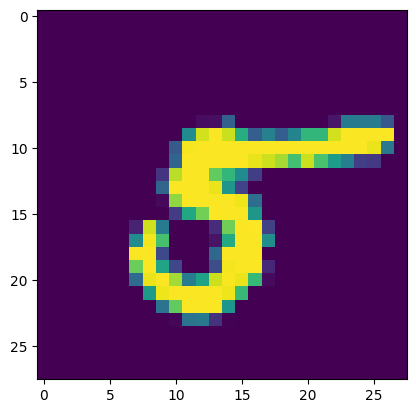

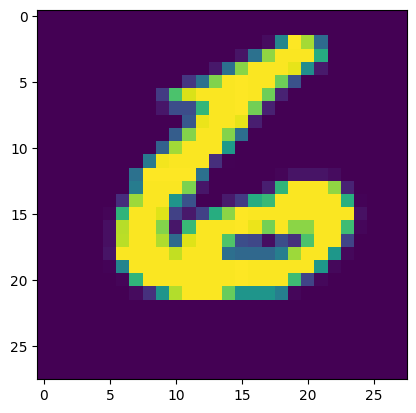

In [ ]:
import matplotlib.pyplot as plt

# Get the images from the dataset
for i in range(10):
  image = X[i]
  # Plot the image
  plt.imshow(image.numpy().reshape(28, 28))
  plt.show()

## Carga de datos


Esta sección barajará nuestros datos de entrada/entrenamiento para que tengamos una mezcla aleatoria de nuestros datos y no corramos el riesgo de alimentar datos con un patrón. Otro objetivo aquí es enviar los datos en lotes. Este es un buen paso a seguir para asegurarse de que la red neuronal no se sobreajuste a nuestros datos. Las redes neuronales son muy propensas al sobreajuste debido a la enorme cantidad de datos que se requiere. Para cada tamaño de lote, la red neuronal ejecutará una retropropagación para actualizar los pesos y tratar de disminuir la pérdida cada vez.

In [ ]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

## Inicialización de la red neuronal

**Observaciones**
- Para la capa de entrada, debemos establecer una cantidad de entradas igual a la cantidad de atributos que tienen los datos, que en este caso es de 784 pixeles por imagen.
- La cantidad de salidas de una capa debe ser igual a la cantidad de entradas de la capa siguiente.
- La capa de salida debe tener 10 outputa, ya que es un problema de clasificación con 10 categorías.

In [ ]:
# Definimos una clase Net que hereda de nn.Module para crear nuestra red neuronal
class Net(nn.Module):
    # Definimos el constructor de la clase
    def __init__(self):
        super().__init__()  # Inicializa la clase base nn.Module
        self.fc1 = nn.Linear(28*28, 64)  # Primera capa totalmente conectada (entrada de 784, salida de 64)
        self.fc2 = nn.Linear(64, 64)  # Segunda capa totalmente conectada (entrada de 64, salida de 64)
        self.fc3 = nn.Linear(64, 64)  # Tercera capa totalmente conectada (entrada de 64, salida de 64)
        self.fc4 = nn.Linear(64, 10)  # Cuarta capa totalmente conectada (entrada de 64, salida de 10)

    # Definimos el método forward que especifica cómo se pasan los datos a través de la red
    def forward(self, x):
        x = self.fc1(x)  # Pasa los datos por la primera capa
        x = self.fc2(x)  # Pasa los datos por la segunda capa
        x = self.fc3(x)  # Pasa los datos por la tercera capa
        x = self.fc4(x)  # Pasa los datos por la cuarta capa
        return F.log_softmax(x, dim=1)  # Aplica la función log_softmax en la salida

# Creamos una instancia de la red neuronal definida
net = Net()

# Imprimimos la arquitectura de la red neuronal
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


## Entrenamiento, cálculo de pérdida y optimización por etapas

In [ ]:
# Calcular nuestra pérdida
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in tqdm(range(10)):  # usamos 5 épocas
    for data in trainset:  # `data` es un lote de datos
        X, y = data  # X es el lote de características, y es el lote de objetivos.

        net.zero_grad()  # establece los gradientes en 0 antes de calcular la pérdida.

        output = net(X.view(-1, 784))  # pasa el lote reestructurado (recuerda que son 28x28 atm, -1 es necesario para mostrar que la salida puede ser de n dimensiones. Esta es una sintaxis exclusiva de PyTorch)

        loss = F.nll_loss(output, y)  # calcula y obtiene el valor de la pérdida

        loss.backward()  # aplica esta pérdida hacia atrás a través de los parámetros de la red

        optimizer.step()  # intenta optimizar los pesos para compensar la pérdida/los gradientes
    print('Pérdida después de la época '+str(epoch)+': ', loss)


  0%|          | 0/10 [00:00<?, ?it/s]

Pérdida después de la época 0:  tensor(1.2675, grad_fn=<NllLossBackward0>)
Pérdida después de la época 1:  tensor(0.9416, grad_fn=<NllLossBackward0>)
Pérdida después de la época 2:  tensor(0.2155, grad_fn=<NllLossBackward0>)
Pérdida después de la época 3:  tensor(0.5722, grad_fn=<NllLossBackward0>)
Pérdida después de la época 4:  tensor(0.0997, grad_fn=<NllLossBackward0>)
Pérdida después de la época 5:  tensor(0.5970, grad_fn=<NllLossBackward0>)
Pérdida después de la época 6:  tensor(0.5523, grad_fn=<NllLossBackward0>)
Pérdida después de la época 7:  tensor(0.3252, grad_fn=<NllLossBackward0>)
Pérdida después de la época 8:  tensor(0.8985, grad_fn=<NllLossBackward0>)
Pérdida después de la época 9:  tensor(0.1499, grad_fn=<NllLossBackward0>)


## Evaluación de la red

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print(output)
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.918
